In [1]:
# Imports and stable code

# Standard library imports
import time
import math
import copy
import os
os.environ["JULIA_NUM_THREADS"] = "1"
from julia.api import Julia
julia = Julia(sysimage="sysimage_env/sysimage.so")
from julia import Main
Main.include("models/memory_model.jl")
Main.include("models/Reinfection_model.jl")

import shutil
from tempfile import NamedTemporaryFile
import multiprocessing
import re
import sqlite3

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, dual_annealing, direct, brute, OptimizeResult
from scipy.stats import qmc
from joblib import Parallel, delayed

# Infrastructure functions

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class NoOpMinimizer:
    def __call__(self, x):
        return x

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dE",  # d_E -> d subscript E
        r"\bdelta\b": "δ",  # delta -> δ
        r"\bdelta_E\b": "δE",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K(δE)",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",  # delta_E/K_delta_E -> δ subscript E/K subscript δ subscript E
        r"\bdelta/delta_E\b": "δ/δE",  # delta/delta_E -> δ divided by δ subscript E
        r"\beta\b": "η",  # eta -> η
        r"\bzeta\b": "ζ",  # zeta -> ζ
        r"\btau_memory\b": "τm",  # tau_memory -> τ subscript m
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

# Curent development area 
class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, method='fixed', space='log10'):
        self.name = name
        self.space = space
        self.l_lim = self._transform_space(l_lim)
        self.u_lim = self._transform_space(u_lim)
        self.val = val
        self.method = method

    def _transform_space(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound

    def _inverse_transform_space(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        if self.space == 'log10':
            values = 10 ** values  # Inverse transform back to natural space
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, scale: float = 1.0):
        self.label = label
        self.initial_value = initial_value
        self.time_points = np.array([0.0])
        self.sse = sse
        self.scale = scale

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, sse={self.sse})"

class States:
    def __init__(self, states_config: list):
        self.states = {config['label']: State(**config) for config in states_config}
        self.state_labels = [state.label for state in self.states.values()]

    def __getattr__(self, name: str) -> float:
        return self.states[name].get_latest_value()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, sse={self.sse})"
    
class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, df_params=None, sol=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf, reinfection=False):
        self.id = id
        self.color = color
        self.t_span = t_span
        self.df = df
        self.parameters = parameters
        self.states = states
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise
        self.reinfection = reinfection
        # print('patient', reinfection)

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)
        self.param_names = list(self.parameters._parameters.keys())
        self.results_in_memory = []  # To store results for later DB writes

    def solve(self):
        try:
            #print('solve', self.reinfection)
            self.sol = JuliaSolve((
                self.parameters, self.states, self.t_span, self.reinfection
            ))
        except Exception as e:
            self.sol = None
            print(f"Error solving patient {self.id}: {e}")
    
    def compare(self):
        df = self.df
        shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312] + [i for i in range(1, 45) if i not in {10, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44}]
        targets = [self.id]

        # States to include in SSE computation
        states_to_sse = ['V', 'CD8TE', 'CD8TM']

        for pid in targets:
            if isinstance(pid, str) and pid == 'Population':
                pid_df = df[df['VOLUNTEER'].isin(shedders)]
                pid_df['VOLUNTEER'] = 'Population'
            elif isinstance(pid, str) and pid == 'Murine':
                murine_ids = list(range(10))
                pid_df = df[df['VOLUNTEER'].isin(murine_ids)]
                pid_df['VOLUNTEER'] = 'Murine'
            else:
                pid_df = df[df['VOLUNTEER'].isin([pid])]

            # Initialize SSE array
            sse_array = [0] * len(self.states)
            total_sse = 0

            for idx, state in enumerate(self.states):
                state_label = state['label']
                if state_label in states_to_sse and state_label in pid_df.columns:
                    data_values = pid_df[state_label].values
                    time_points = pid_df['DAY'].values
                    valid_indices = ~np.isnan(data_values)
                    data_values = data_values[valid_indices]
                    time_points = time_points[valid_indices]

                    if len(data_values) > 0:
                        model_time_points = self.sol.t
                        model_values = self.sol.y[idx]

                        if model_values.shape[0] != len(model_time_points):
                            model_values = np.transpose(model_values)

                        # Interpolate model values to data time points
                        interpolated_model_values = np.interp(time_points, model_time_points, model_values)

                        # Calculate SSE for this state
                        state_sse = 0
                        for data_val, model_val, time in zip(data_values, interpolated_model_values, time_points):
                            log_diff = (np.log10(max(data_val, 1.0)) - np.log10(max(model_val, 1.0))) ** 2
                            if state_label in ['CD8TE', 'CD8TM'] and time == 0:
                                    log_diff *= 10  # Apply weight of 10 for Time = 0 and CD8TE, CD8TM 
                            state_sse += log_diff

                        sse_array[idx] = state_sse

                        # Accumulate total SSE if the state contributes to SSE
                        if state.get('sse', True):
                            total_sse += state_sse

            # Store total SSE and state-wise SSE
            self.sse = total_sse
            self.sse_statewise = sse_array

            # Extract SSE for specific columns
            state_indices = {state['label']: idx for idx, state in enumerate(self.states)}
            sse_db_components = {label: sse_array[state_indices[label]] for label in states_to_sse if label in state_indices}
            sse_db = sum(sse_db_components.values())

            # Store parameters and SSEs in memory
            all_params = [param.val for param in self.parameters._parameters.values()]
            self.results_in_memory.append((all_params, list(sse_db_components.values()) + [sse_db], str(pid)))

    def objective_function(self, x):
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**x[i]
            else:
                self.parameters._parameters[name].val = x[i]

        self.solve()
        self.compare()

        return self.sse
    
    def write_results_to_db(self, path):
        conn = sqlite3.connect(path)
        cursor = conn.cursor()
        cursor.executemany('''
            INSERT INTO evaluations (
                E0, M0, ME, T0, I10, beta, k, p, c, delta, xi, a, d_E, delta_E, K_delta_E,
                zeta, eta, K_I1, tau_memory, damp, V_sse, CD8TE_sse, CD8TM_sse, sse, PID
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', [tuple(p) + tuple(e) + (pid,) for p, e, pid in self.results_in_memory])
        conn.commit()
        conn.close()
        self.results_in_memory = [] # Flush the results from memory
        print(f'Results saved to {path}.',flush=True)

    def optimize_parameters(self, method='halton', iter=1000, verbose=False, path='output', local_iter=2500, local_method='Nelder-Mead', buff=True):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method in ['fit', 'refine']}

        if not fit_parameters:
            print("No parameters to optimize")
            self.solve()
            self.compare()
            return (None, self)

        initial_values = []
        for param in fit_parameters.values():
            if param.method == 'fit':
                sampled_value = np.random.uniform(param.l_lim, param.u_lim)
                initial_values.append(sampled_value)
            elif param.method == 'refine':
                initial_values.append(param.val)

        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        self.param_names = list(fit_parameters.keys())  # Save param_names as instance variable
        number_fit = len(self.param_names)

        minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': local_iter,
            }}
        if method == 'differential_evolution':
            print(f'{self.id} Differential Evolution with {iter} generations.',flush=True)
            result = differential_evolution(
                self.objective_function,
                bounds=bounds,
                strategy='best1bin',
                maxiter=iter,
                popsize=100,
                mutation=(0.7, 1.9),
                recombination=0.7,
                disp=verbose,
                polish=False,
                init='halton',
                workers=1, 
                vectorized=False,
                updating='immediate' 
            )
        elif method == 'dual_annealing':
            print(f'{self.id} Dual Annealing with {iter} iterations.', flush=True)
            result = dual_annealing(
                self.objective_function,
                bounds=bounds,
                x0=initial_values,
                no_local_search=False
            )
        elif method == 'direct':
            print(f'{self.id} Direct method optimization.', flush=True)
            result = direct(
                self.objective_function,
                bounds=bounds,
                args=(), 
                eps=1E-7, 
                maxfun=None,  
                maxiter=iter,  
                locally_biased=False,  
                f_min=-np.inf,  
                f_min_rtol=1E-9,  
                vol_tol=1e-16,  
                len_tol=1e-06, 
                callback=None 
            )
        elif method == 'brute':
            print(f'{self.id} Brute force optimization.', flush=True)
            result = brute(
                self.objective_function,
                ranges=bounds,
                full_output=True,
                finish=None,  
                workers=1,
                disp=verbose
            )
        elif method == 'shgo':
            print(f'{self.id} SHGO optimization.', flush=True)
            result = shgo(
                self.objective_function,
                bounds=bounds,
                constraints=None,
                n=100, 
                iters=1,  
                sampling_method='sobol', 
                options={
                    'disp': verbose,
                    'maxiter': iter,  
                    'ftol': 1e-6, 
                    'xatol': 1e-6,  
                    'fatol': 1e-6,  
                }
            )
        elif method == 'ASA':
            result = ASA(
                self.objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=iter,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        elif method == 'basin_hopping':
            class BoundedStep:
                def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                    self.fit_parameters = fit_parameters
                    self.stepsize = stepsize
                    self.normal_sampling = normal_sampling
                    self.precomputed = {}

                    for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                        lower, upper = param.l_lim, param.u_lim
                        if param.space == 'log10':
                            lower, upper = np.log10(lower), np.log10(upper)

                        self.precomputed[i] = {
                            'lower': lower,
                            'upper': upper,
                            'range': upper - lower,
                            'is_log': param.space == 'log10'
                        }

                def __call__(self, x):
                    rng = np.random.default_rng()

                    for i in range(len(x)):
                        bounds = self.precomputed[i]
                        lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                        if self.normal_sampling:
                            step = rng.normal(0, self.stepsize)
                            step = np.clip(step, -3, 3)
                            normalized_step = (step + 3) / 6
                        else:
                            normalized_step = rng.uniform()

                        step = (normalized_step - 0.5) * self.stepsize * range_
                        x[i] = np.clip(x[i] + step, lower, upper)

                        if is_log:
                            x[i] = 10 ** x[i]

                    return x

            print(f'{self.id} Basin Hopping with n = {iter}',flush=True)
            result = basinhopping(
                self.objective_function,  
                x0=initial_values,
                niter=iter,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                interval=1,
                disp=verbose,
                niter_success=2,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )
        elif method == 'halton':
            print(f'{self.id} Halton with n = {iter}', flush=True)
            # Halton sampling-based optimization
            sampler = qmc.Halton(d=number_fit)
            n_samples = iter  # Number of samples for Halton sequence
            step_size = n_samples // 20  # 5% of n_samples

            # Generate Halton samples in [0, 1] and scale them to the parameter bounds
            halton_samples = sampler.random(n_samples)
            scaled_samples = qmc.scale(halton_samples, [b[0] for b in bounds], [b[1] for b in bounds])
            best_sample = None
            best_sse = np.inf
            progress_count = 0

            for i, sample in enumerate(scaled_samples):
                sse = self.objective_function(sample)
                if sse < best_sse:
                    best_sse = sse
                    best_sample = sample

                # Print progress every 5% 
                if (i + 1) % step_size == 0:
                    progress_count += 5
                    print(f"Progress: {progress_count}% of samples evaluated ({i+1}/{n_samples})")

            # Assign the best-found parameters back to the model
            result = OptimizeResult()
            result.x = best_sample
            result.fun = best_sse

        if buff == True:
            # Local solver "buff" (polish, but that keyword is used in some global algos already)
            fallback_minimizer_kwargs = {
                'method': 'L-BFGS-B',
                'bounds': bounds,
                'options': {
                        'xatol': 1e-6,
                        'fatol': 1e-6,
                        'disp': True,
                        'maxiter': 1E4,
                }}
            print(f'{self.id} polish', flush=True)
            result = minimize(
                self.objective_function, 
                x0=result.x if 'result' in locals() else initial_values,
                **fallback_minimizer_kwargs
            )
        else:
            result = OptimizeResult()
            result.x = result.x if 'result' in locals() else initial_values

        # Write results to database
        db_path = f'sql/{path}.db'
        os.makedirs('sql', exist_ok=True)
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS evaluations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                E0 REAL, M0 REAL, ME REAL, T0 REAL, I10 REAL, beta REAL, k REAL,
                p REAL, c REAL, delta REAL, xi REAL, a REAL,
                d_E REAL, delta_E REAL, K_delta_E REAL, zeta REAL, eta REAL, K_I1 REAL, tau_memory REAL,
                damp REAL, V_sse REAL, CD8TE_sse REAL, CD8TM_sse REAL, sse REAL, PID REAL
            )
        ''')
        conn.commit()
        conn.close()
        self.write_results_to_db(path=db_path)

        # Final update of parameters
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**result.x[i]
            else:
                self.parameters._parameters[name].val = result.x[i]
            print(f'Parameter {name}: {self.parameters._parameters[name].val}')

        # Solve and compare with the best-found parameters
        self.solve()
        self.results_in_memory = []
        Main.GC.gc()

        return (result, self)
    
    def __repr__(self):
        return f"Patient({self.id}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, parameter_file=None, reinfection=False):
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df
        self.parameters = parameters
        self.states = states
        self.reinfection = reinfection
        #print('patients', reinfection)
        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.df_params,
                reinfection=self.reinfection,
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, opt_target, method, iter, path, verbose=False, local_iter=1000, local_method='L-BFGS-B'):
        results = []
        for patient in self.patients.values():
            if patient.id == opt_target:
                result = patient.optimize_parameters(method=method, iter=iter, verbose=verbose, path=path, local_iter=local_iter, local_method=local_method)
                results.append(result)
        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

class JuliaODESolution:
    def __init__(self, t, y):
        self.t = np.array(t)  # Time points
        self.y = np.array(y)  # Transposed solution values (states over time)

    def __repr__(self):
        return f"JuliaODESolution(t={self.t}, y={self.y})"

def solve_with_julia(t_span, y0, params, reinfection=False):
    t_span = (float(np.float64(t_span[0])), float(np.float64(t_span[-1])))
    y0 = [float(np.float64(val)) for val in y0]
    #print('solve_with_julia', reinfection)
    if reinfection == False:
        params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["xi"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["zeta"])),
        float(np.float64(params["eta"])),
        float(np.float64(params["K_I1"])),
        float(np.float64(params["tau_memory"])),
        ]
        t_values, y_values = Main.tmap_LCTModel(t_span, y0, params_julia)
    else:
        params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["xi"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["zeta"])),
        float(np.float64(params["eta"])),
        float(np.float64(params["K_I1"])),
        float(np.float64(params["tau_memory"])),
        float(np.float64(params["damp"])),
        ]
        t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0, params_julia)
    t_values = np.array(t_values, dtype=np.float64)
    y_values = np.array(y_values, dtype=np.float64)

    return JuliaODESolution(t=t_values, y=y_values)

def JuliaSolve(task):
    def inner_solve(param_set, states_config, t_span, reinfection):
        #print('JuliaSolve', reinfection)
        states_config_copy = states_config.copy()
        # Prepare parameters and initial conditions for Julia
        params = {
            "beta": param_set.beta.val,
            "k": param_set.k.val,
            "p": param_set.p.val,
            "c": param_set.c.val,
            "delta": param_set.delta.val,
            "xi": param_set.xi.val,
            "a": param_set.a.val,
            "d_E": param_set.d_E.val,
            "delta_E": param_set.delta_E.val,
            "K_delta_E": param_set.K_delta_E.val,
            "zeta": param_set.zeta.val,
            "eta": param_set.eta.val,
            "K_I1": param_set.K_I1.val,
            "tau_memory": param_set.tau_memory.val,
            "damp": param_set.damp.val,
        }

        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
        y0[0] = param_set.T0.val
        y0[1] = param_set.I10.val
        y0[5] = param_set.ME.val
        sol = solve_with_julia(t_span, y0, params, reinfection=reinfection)
        sol.y[4] += param_set.E0.val  # Add the background T Effectors (E0)
        sol.y[5] += param_set.M0.val  # Add the background T Effector Memory (M0)
        return sol

    sol = inner_solve(*task)
    return sol

def plot_per_patient_both_sets(
    results,
    results_rechallenge,
    subplot_config,
    t_span=[0, 10],
    figsize=(10,5),
    patient_color='blue',
    save=True
):

    # Prepare x-ticks
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)

    # Determine subplot grid
    n_subplots = len(subplot_config)
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows = int(np.ceil(np.sqrt(n_subplots)))
        n_cols = int(np.ceil(n_subplots / n_rows))

    # Font sizes
    base_font_size = 14
    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    # We'll loop over both sets simultaneously using zip(...)
    # We assume results and results_rechallenge have the same length and matching patients.
    for (res_obj1, patient1), (res_obj2, patient2) in zip(results, results_rechallenge):
        # Typically patient1 and patient2 represent the SAME patient (same ID)
        patient_id = patient1.id  # hopefully patient2.id matches

        # Collect fit parameters from the first scenario (you could combine both if needed)
        fit_parameters = [
            param_name
            for param_name, param in patient1.parameters._parameters.items()
            if param.method == 'fit'
        ]
        fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""

        # Create figure and subplots for this patient
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()

        # Figure title
        title_str = f"Patient {patient_id}: {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)

        # Plot each subplot
        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]

            # Plot data from the first scenario (results)
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]
            markers = ['o', 's', '^', 'D', 'v']
            
            for j, data_key in enumerate(data_keys):
                if data_key:
                    # Filter volunteer data for this patient
                    volunteer_data = patient1.df[
                        patient1.df['VOLUNTEER'] == patient_id
                    ].copy()
                    ax.plot(
                        volunteer_data['DAY'],
                        np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                        marker=markers[j % len(markers)],
                        color=patient_color,
                        linestyle='None',
                        alpha=1.0,
                        zorder=15
                    )

            # Plot model solution from the first scenario (results)
            sol_keys = config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']]
            linestyles = ['-', '--', '-.', ':']
            if patient1.sol:
                sol_t = patient1.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient1.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color=patient_color,
                        linestyle=linestyles[k % len(linestyles)],
                        alpha=1.0
                    )
            
            # Now plot data + model lines from the second scenario (results_rechallenge) in black
            if patient2.df is not None:
                for j, data_key in enumerate(data_keys):
                    if data_key:
                        volunteer_data = patient2.df[
                            patient2.df['VOLUNTEER'] == patient2.id
                        ].copy()
                        ax.plot(
                            volunteer_data['DAY'],
                            np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                            marker=markers[j % len(markers)],
                            color=patient_color,
                            linestyle='None',
                            alpha=1.0,
                            zorder=15
                        )
            if patient2.sol:
                sol_t = patient2.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient2.sol.y[sol_key]
                    #print(sol_y_raw)
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color='black',
                        linestyle=linestyles[k % len(linestyles)],
                        alpha=1.0
                    )

            # Axis limits, labels, etc.
            if 'ylims' in config and config['ylims']:
                ax.set_ylim(config['ylims'])
            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('Time (d)', fontsize=label_font_size)
            # Label y-axis based on first data_key (if present)
            if len(data_keys) > 0 and data_keys[0]:
                if 'V' in data_keys:
                    ax.set_ylabel(f'Virus (log$_{{10}}$ copies/mL)', fontsize=label_font_size)
                elif 'CD8TE' in data_keys:
                    ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
                elif 'CD8TM' in data_keys:
                    ax.set_ylabel(f'CD8$^+$ T (log$_{{10}}$ cells)', fontsize=label_font_size)
                else:
                    ax.set_ylabel(f'log$_{{10}}$ ({data_keys[0]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

        # Hide unused subplots if any
        for extra_ax in axs_flat[len(subplot_config):]:
            extra_ax.set_visible(False)

        plt.tight_layout()

        # Save the figure if desired
        save_dir = os.path.join('plots', f'Patient_{patient_id}')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [8]:
# Setup 
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
targets = ['Population']
ids = targets + shedders
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': ['CD8TE','CD8TM'], 'sol_key': [4, 5], 'ylims': [3,7.5]}, 
    #{'title': 'T Memory', 'data_key': 'CD8TM', 'sol_key': 5, 'ylims': [3,5.25]}, 
]

n_Z = 13
# Import data
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='Main')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]

Parameter 'damp' for ID Population is missing in the parameter file. Falling back to original values.
No parameters to optimize
No parameters to optimize


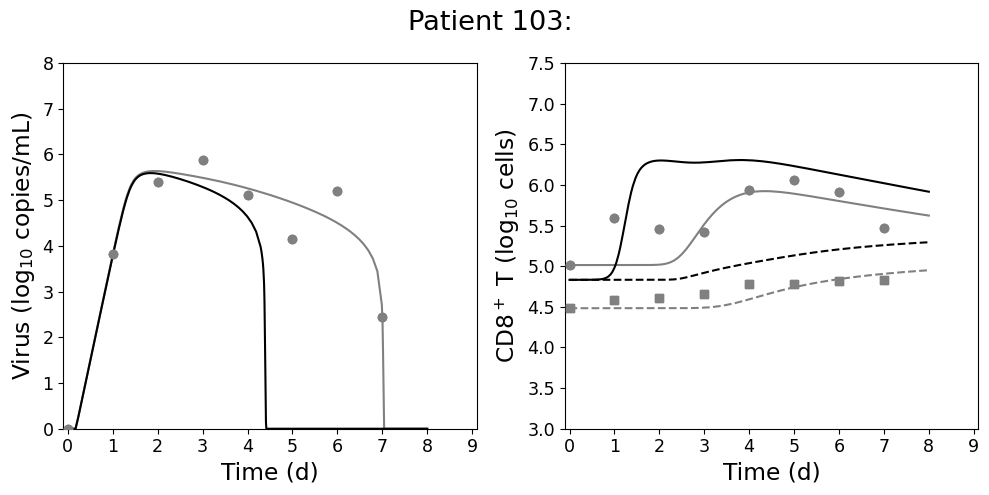

No parameters to optimize
No parameters to optimize


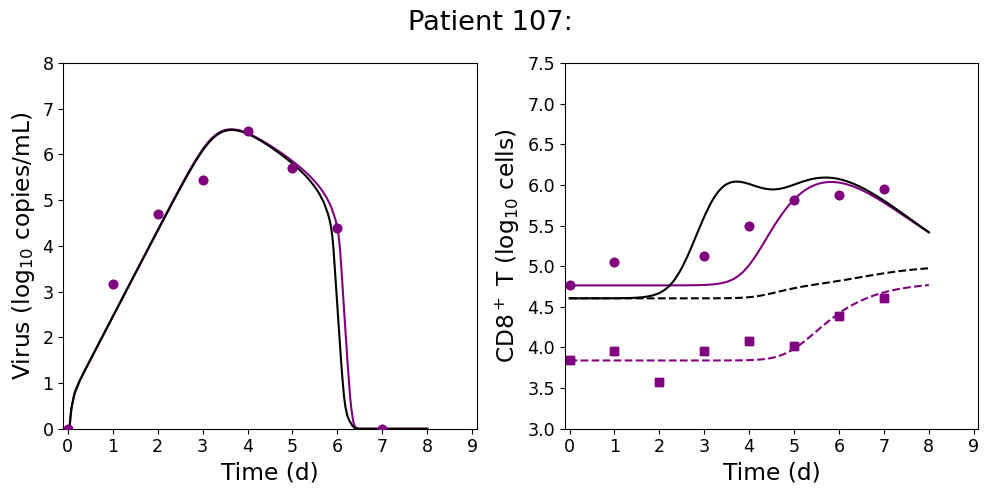

No parameters to optimize
No parameters to optimize


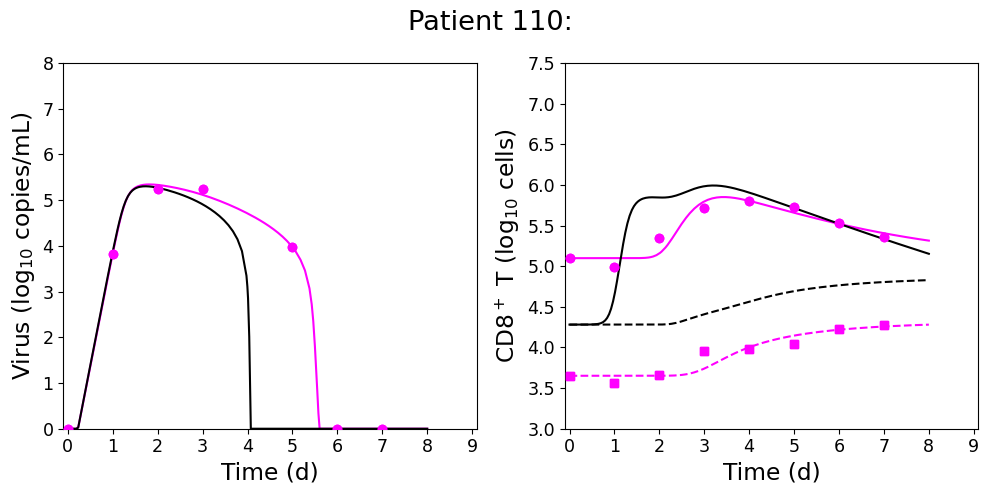

No parameters to optimize
No parameters to optimize


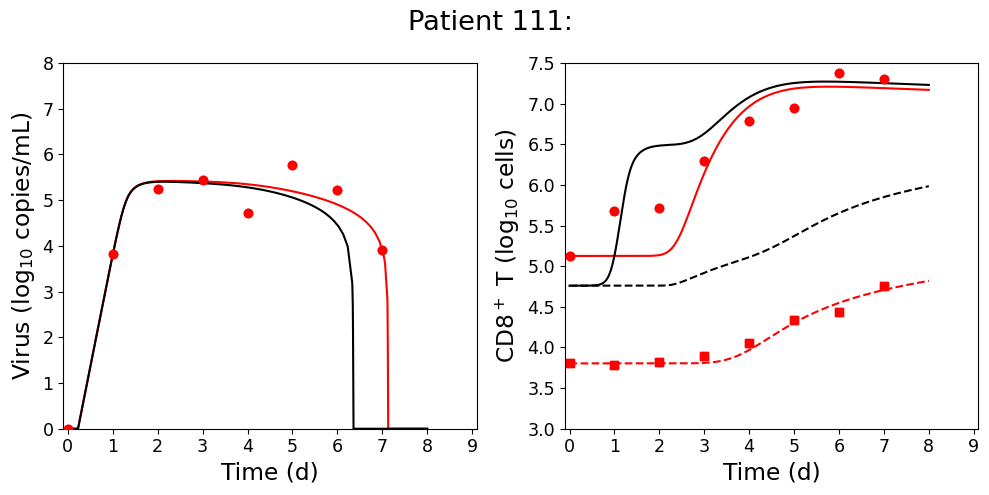

No parameters to optimize
No parameters to optimize


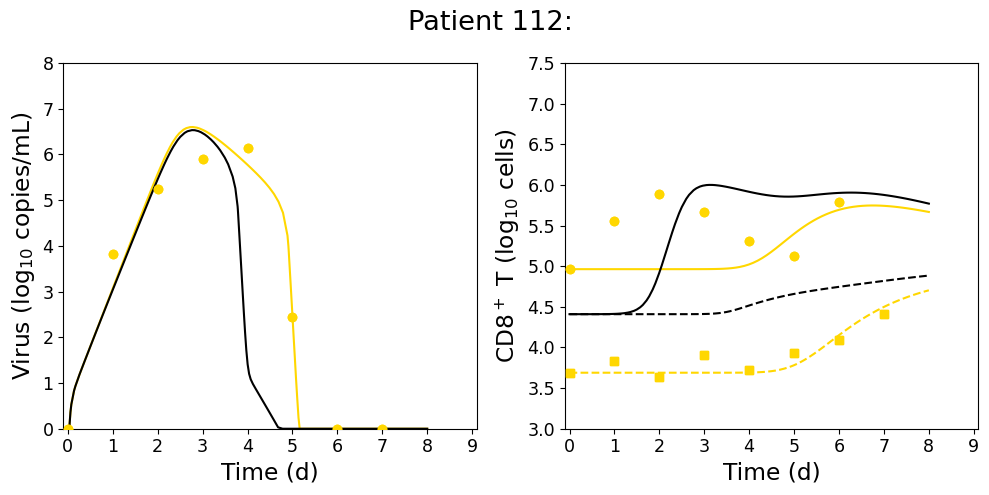

No parameters to optimize
No parameters to optimize


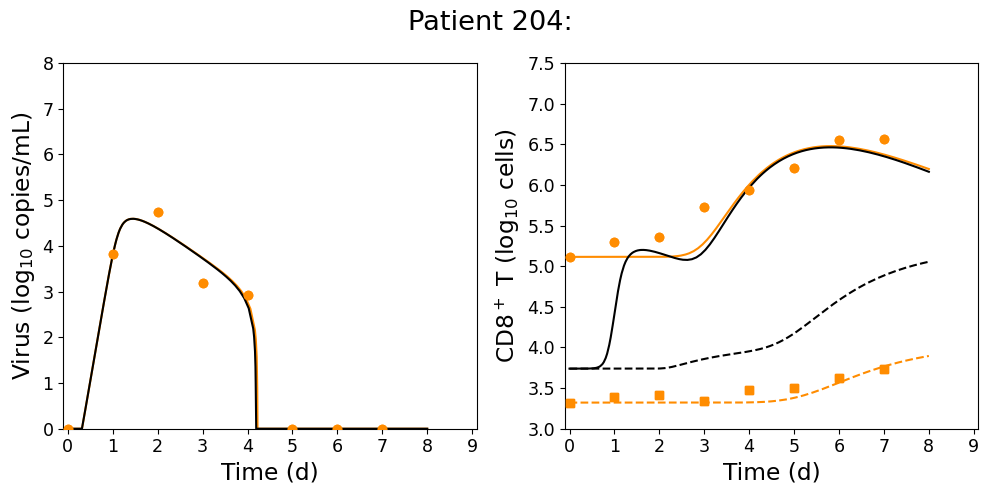

No parameters to optimize
No parameters to optimize


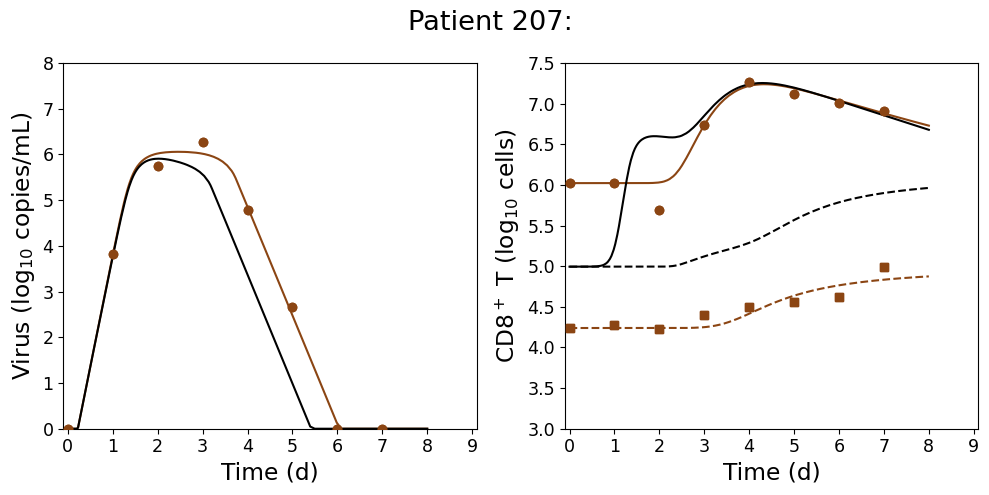

No parameters to optimize
No parameters to optimize


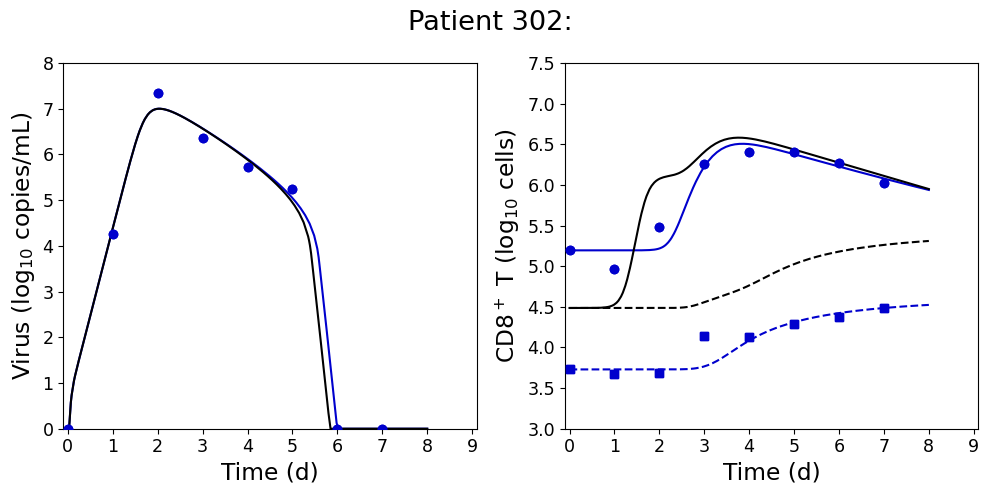

No parameters to optimize
No parameters to optimize


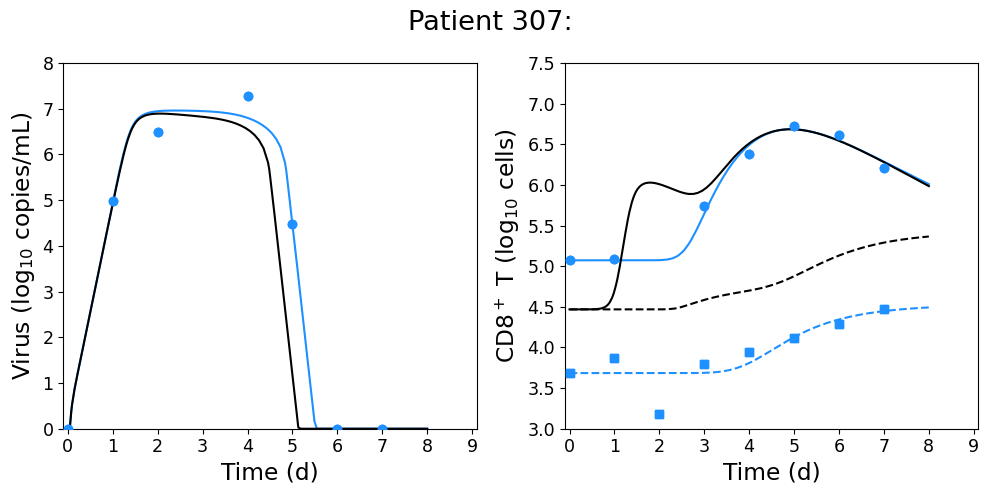

No parameters to optimize
No parameters to optimize


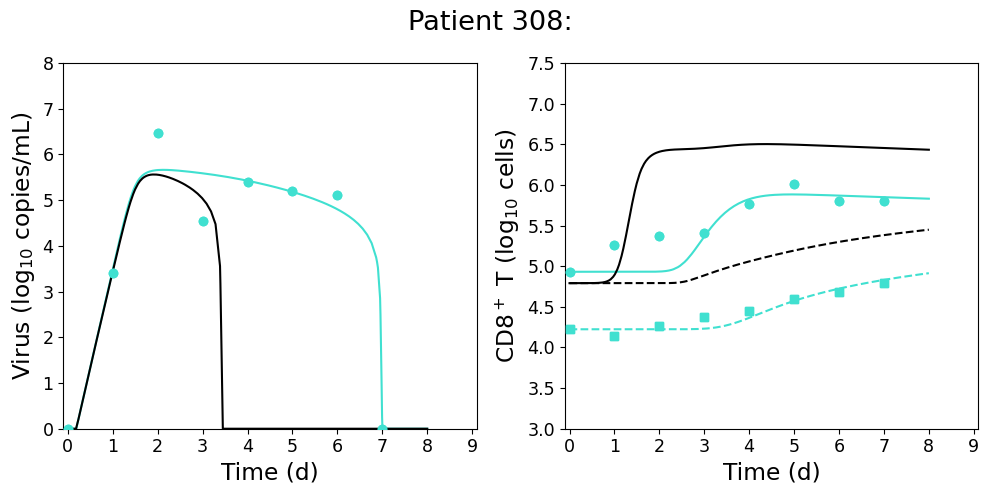

No parameters to optimize
No parameters to optimize


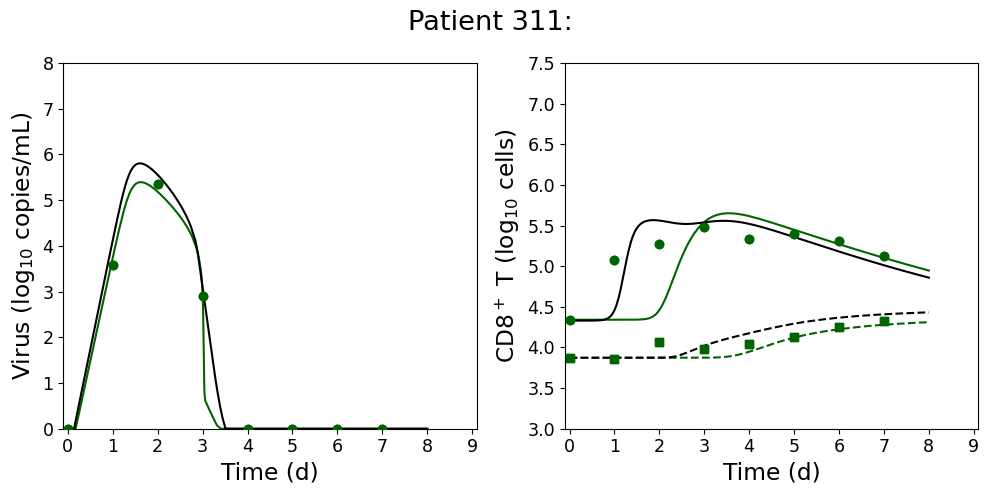

No parameters to optimize
No parameters to optimize


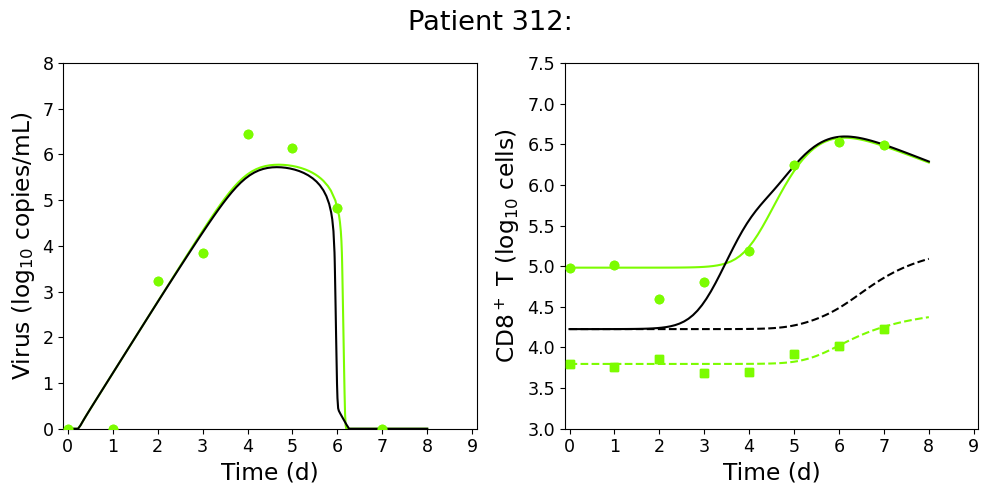

In [9]:
# Rechallenge Forecast

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=0.05, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='file', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='file', space='log10'),
    xi=Parameter(name='xi', val=0.0, l_lim=0.05, u_lim=10, method='file', space='log10'), 
    a=Parameter(name='a', val=0.0, l_lim=1.0, u_lim=10, method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='file', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='file', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='file', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='file', space='normal'),
    damp=Parameter(name='damp', val=10, l_lim=1.0, u_lim=10, method='fixed', space='normal')
)

parameters_rechallenge = Parameters(
    E0=Parameter(name='E0', val=0, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'),
    M0=Parameter(name='M0', val=0, l_lim=2E4, u_lim=3E5, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='file', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=7.84E-5, l_lim=1E-6, u_lim=1E-3, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=2.977, l_lim=0.1, u_lim=10.0, method='file', space='normal'), 
    c=Parameter(name='c', val=160, l_lim=10.0, u_lim=250, method='file', space='log10'), 
    delta=Parameter(name='delta', val=3.29, l_lim=0.25, u_lim=5, method='file', space='normal'),
    xi=Parameter(name='xi', val=0.04298, l_lim=1E-2, u_lim=5.0, method='file', space='log10'), 
    a=Parameter(name='a', val=7.3921, l_lim=1.0, u_lim=10, method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=0.76, l_lim=0.3, u_lim=2.0, method='file', space='normal'),
    delta_E=Parameter(name='delta_E', val=14, l_lim=0.5, u_lim=15.0, method='file', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=9771, l_lim=1E2, u_lim=1E5, method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.014, l_lim=1E-3, u_lim=1.0, method='fixed', space='log10'),
    eta=Parameter(name='eta', val=1e-5, l_lim=1e-8, u_lim=1e-4, method='file', space='log10'), 
    K_I1=Parameter(name='K_I1', val=45678, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=1.01, l_lim=0.1, u_lim=1.0, method='fixed', space='normal'),
    damp=Parameter(name='damp', val=10, l_lim=1.0, u_lim=10, method='file', space='normal')
)

t_span = (0, 8)
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
patients_rechallenge = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters_rechallenge, states=states, parameter_file='LinearRechallenge.xlsx', reinfection=True)
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='PrimaryInfectionn')
    results_rechallenge = patients_rechallenge.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Reinfection_testing')
    patient_color = color_mapping.get(target, 'black') 
    plot_per_patient_both_sets(
        results=results,
        results_rechallenge=results_rechallenge,
        subplot_config=subplot_configuration,
        t_span=[0,9],
        figsize=(10,5),
        patient_color=patient_color,
        save=True
    )